<a href="https://colab.research.google.com/github/sujay-dsa/ComputerVision/blob/master/EVA5_session5_Step_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

> We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

> As a first step, we will normalize the the values of the input images with the mean and std dev of the entire dataset. We'll create two separate transforms, one for test and the other for training. We'll tweak only the training transforms when we revisit the model for fine tuning.

We'll Normalize the test dataset with the training standard deviation and mean because this is the parameter our model will know in real world. 

In [14]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation(10),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1305,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1305,), (0.3081,))
                                       ])


## Dataset and Creating Train/Test Split



In [15]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

## Dataloader Arguments & Test/Train Dataloaders

Here we define the batch size and specify the number of worker threads to work on randomly images for the batch, normalizing them and sending them to the GPU / CPU. 

In [16]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## The model

We'll rewrite the model for easier readability and tweaking later on

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -? OUtput? RF
        self.conv2 = nn.Conv2d(32, 256, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(64, 32, 3)
        self.conv6 = nn.Conv2d(32, 16, 3)
        self.conv7 = nn.Conv2d(16, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        # x = F.relu(self.conv7(x))
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)
    

In [27]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),  
            nn.BatchNorm2d(32),          
            nn.ReLU()
        ) 

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 


        # CONVOLUTION BLOCK 3
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        ) # output_size = 

        # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ) # output_size = 

        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 

        # CONVOLUTION BLOCK 5
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 

        # CONVOLUTION BLOCK 6
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        #self.convblock8 = nn.Sequential(
         #   nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        #) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x) # we can pool here as receptive field is around 5
        x = self.convblock3(x)        
        x = self.convblock4(x)
        x = self.pool2(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        #x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Params

Since there's no inbuilt tool to summarize the model parameters, we'll use torchsummary

In [28]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             288
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4          [-1, 256, 28, 28]          73,728
       BatchNorm2d-5          [-1, 256, 28, 28]             512
              ReLU-6          [-1, 256, 28, 28]               0
         MaxPool2d-7          [-1, 256, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]         294,912
       BatchNorm2d-9          [-1, 128, 14, 14]             256
             ReLU-10          [-1, 128, 14, 14]               0
           Conv2d-11           [-1, 64, 14, 14]          73,728
      BatchNorm2d-12           [-1, 64, 14, 14]             128
             ReLU-13           [-1, 64, 14, 14]               0
        MaxPool2d-14             [

## Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce tqdm progressbar to get cooler logs.

Let's write train and test functions

In [29]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Let's Train and test our model



In [30]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15 #change from 20 to 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.10302463173866272 Batch_id=468 Accuracy=96.50: 100%|██████████| 469/469 [00:34<00:00, 13.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9905/10000 (99.05%)

EPOCH: 1


Loss=0.0728292390704155 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:34<00:00, 13.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9915/10000 (99.15%)

EPOCH: 2


Loss=0.007221411447972059 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:34<00:00, 13.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9934/10000 (99.34%)

EPOCH: 3


Loss=0.0037007955834269524 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:34<00:00, 13.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9945/10000 (99.45%)

EPOCH: 4


Loss=0.038195520639419556 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:34<00:00, 13.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9948/10000 (99.48%)

EPOCH: 5


Loss=0.002809869358316064 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:34<00:00, 13.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9938/10000 (99.38%)

EPOCH: 6


Loss=0.0017630094662308693 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:34<00:00, 13.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9943/10000 (99.43%)

EPOCH: 7


Loss=0.005338871851563454 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:34<00:00, 13.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 9950/10000 (99.50%)

EPOCH: 8


Loss=0.005584668833762407 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:34<00:00, 13.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9946/10000 (99.46%)

EPOCH: 9


Loss=0.011440199799835682 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:34<00:00, 13.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9944/10000 (99.44%)

EPOCH: 10


Loss=0.0013274903176352382 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:34<00:00, 13.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.0007476457976736128 Batch_id=468 Accuracy=99.76: 100%|██████████| 469/469 [00:34<00:00, 13.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.016539281234145164 Batch_id=468 Accuracy=99.73: 100%|██████████| 469/469 [00:34<00:00, 13.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.01566016860306263 Batch_id=468 Accuracy=99.76: 100%|██████████| 469/469 [00:34<00:00, 13.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9951/10000 (99.51%)

EPOCH: 14


Loss=0.004209254402667284 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:34<00:00, 13.71it/s]



Test set: Average loss: 0.0212, Accuracy: 9930/10000 (99.30%)



Text(0.5, 1.0, 'Test Accuracy')

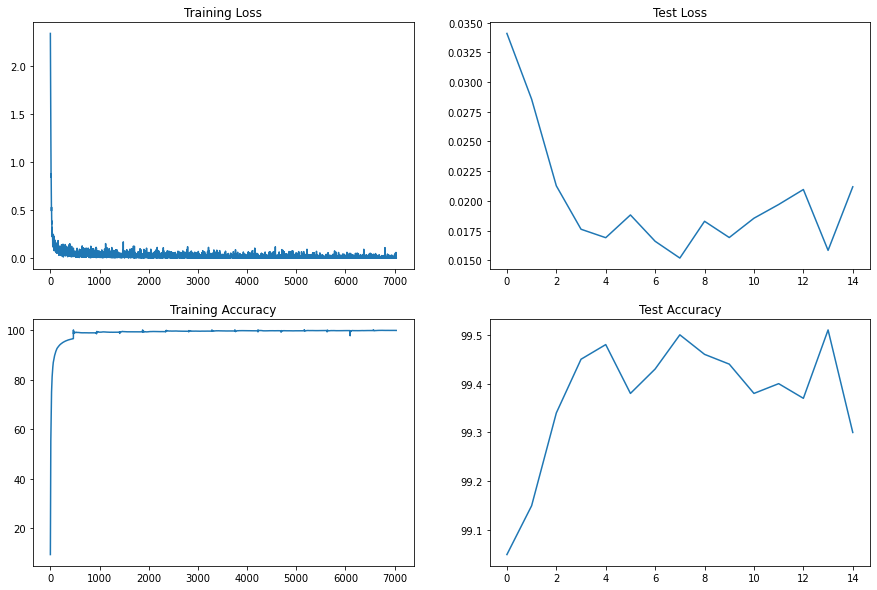

In [31]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Analysis
 Model started overfitting after around epoch 7. So we'll introduce dropout now and see how it things work. There are probably too many neurons learning the same thing. We'll introduce dropouts everywhere, but have higher probabilities where the number of channels are higher. 

In [38]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),  
            nn.BatchNorm2d(32),          
            nn.ReLU(),
            nn.Dropout(0.05)
        ) 

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.15)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 


        # CONVOLUTION BLOCK 3
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 

        # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 

        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 

        # CONVOLUTION BLOCK 5
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.01)
        ) # output_size = 

        # CONVOLUTION BLOCK 6
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.01)
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        #self.convblock8 = nn.Sequential(
         #   nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        #) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x) # we can pool here as receptive field is around 5
        x = self.convblock3(x)        
        x = self.convblock4(x)
        x = self.pool2(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        #x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [39]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             288
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
           Dropout-4           [-1, 32, 28, 28]               0
            Conv2d-5          [-1, 256, 28, 28]          73,728
       BatchNorm2d-6          [-1, 256, 28, 28]             512
              ReLU-7          [-1, 256, 28, 28]               0
           Dropout-8          [-1, 256, 28, 28]               0
         MaxPool2d-9          [-1, 256, 14, 14]               0
           Conv2d-10          [-1, 128, 14, 14]         294,912
      BatchNorm2d-11          [-1, 128, 14, 14]             256
             ReLU-12          [-1, 128, 14, 14]               0
          Dropout-13          [-1, 128, 14, 14]               0
           Conv2d-14           [-1

In [40]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15 #change from 15 to 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0



Loss=2.3157143592834473 Batch_id=0 Accuracy=9.38:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.3157143592834473 Batch_id=0 Accuracy=9.38:   0%|          | 1/469 [00:00<03:31,  2.22it/s]
Loss=2.2880313396453857 Batch_id=1 Accuracy=11.72:   0%|          | 1/469 [00:00<03:31,  2.22it/s]
Loss=2.2880313396453857 Batch_id=1 Accuracy=11.72:   0%|          | 2/469 [00:00<02:42,  2.87it/s]
Loss=2.1942999362945557 Batch_id=2 Accuracy=15.62:   0%|          | 2/469 [00:00<02:42,  2.87it/s]
Loss=2.0880815982818604 Batch_id=3 Accuracy=20.70:   0%|          | 2/469 [00:00<02:42,  2.87it/s]
Loss=2.0880815982818604 Batch_id=3 Accuracy=20.70:   1%|          | 4/469 [00:00<02:06,  3.68it/s]
Loss=2.0440938472747803 Batch_id=4 Accuracy=24.22:   1%|          | 4/469 [00:00<02:06,  3.68it/s]
Loss=1.8442198038101196 Batch_id=5 Accuracy=29.69:   1%|          | 4/469 [00:00<02:06,  3.68it/s]
Loss=1.8442198038101196 Batch_id=5 Accuracy=29.69:   1%|▏         | 6/469 [00:00<01:41,  4.58it/s]
Loss=1.782132744789


Test set: Average loss: 0.0526, Accuracy: 9848/10000 (98.48%)

EPOCH: 1



Loss=0.05095396563410759 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.05095396563410759 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<03:03,  2.55it/s]
Loss=0.0772790014743805 Batch_id=1 Accuracy=97.66:   0%|          | 1/469 [00:00<03:03,  2.55it/s] 
Loss=0.04196470230817795 Batch_id=2 Accuracy=97.66:   0%|          | 1/469 [00:00<03:03,  2.55it/s]
Loss=0.04196470230817795 Batch_id=2 Accuracy=97.66:   1%|          | 3/469 [00:00<02:20,  3.32it/s]
Loss=0.06856729835271835 Batch_id=3 Accuracy=97.66:   1%|          | 3/469 [00:00<02:20,  3.32it/s]
Loss=0.0544627383351326 Batch_id=4 Accuracy=97.81:   1%|          | 3/469 [00:00<02:20,  3.32it/s] 
Loss=0.0544627383351326 Batch_id=4 Accuracy=97.81:   1%|          | 5/469 [00:00<01:49,  4.25it/s]
Loss=0.07214381545782089 Batch_id=5 Accuracy=97.92:   1%|          | 5/469 [00:00<01:49,  4.25it/s]
Loss=0.047407686710357666 Batch_id=6 Accuracy=97.99:   1%|          | 5/469 [00:00<01:49,  4.25it/s]
Loss=0.


Test set: Average loss: 0.0428, Accuracy: 9866/10000 (98.66%)

EPOCH: 2



Loss=0.05196676775813103 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.05196676775813103 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<03:16,  2.38it/s]
Loss=0.02525654248893261 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<03:16,  2.38it/s]
Loss=0.02956792525947094 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<03:16,  2.38it/s]
Loss=0.02956792525947094 Batch_id=2 Accuracy=98.70:   1%|          | 3/469 [00:00<02:29,  3.11it/s]
Loss=0.050919581204652786 Batch_id=3 Accuracy=98.63:   1%|          | 3/469 [00:00<02:29,  3.11it/s]
Loss=0.025697626173496246 Batch_id=4 Accuracy=98.75:   1%|          | 3/469 [00:00<02:29,  3.11it/s]
Loss=0.025697626173496246 Batch_id=4 Accuracy=98.75:   1%|          | 5/469 [00:00<01:55,  4.02it/s]
Loss=0.010400133207440376 Batch_id=5 Accuracy=98.96:   1%|          | 5/469 [00:00<01:55,  4.02it/s]
Loss=0.030087381601333618 Batch_id=6 Accuracy=98.88:   1%|          | 5/469 [00:00<01:55,  4.02it/s]
Lo


Test set: Average loss: 0.0294, Accuracy: 9906/10000 (99.06%)

EPOCH: 3



Loss=0.010637362487614155 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.010637362487614155 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:25,  3.22it/s]
Loss=0.02864556945860386 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:25,  3.22it/s]  
Loss=0.02864556945860386 Batch_id=1 Accuracy=99.22:   0%|          | 2/469 [00:00<02:01,  3.83it/s]
Loss=0.03448275476694107 Batch_id=2 Accuracy=99.22:   0%|          | 2/469 [00:00<02:01,  3.83it/s]
Loss=0.0547960139811039 Batch_id=3 Accuracy=98.83:   0%|          | 2/469 [00:00<02:01,  3.83it/s] 
Loss=0.0547960139811039 Batch_id=3 Accuracy=98.83:   1%|          | 4/469 [00:00<01:36,  4.82it/s]
Loss=0.022967753931879997 Batch_id=4 Accuracy=99.06:   1%|          | 4/469 [00:00<01:36,  4.82it/s]
Loss=0.025670072063803673 Batch_id=5 Accuracy=99.09:   1%|          | 4/469 [00:00<01:36,  4.82it/s]
Loss=0.025670072063803673 Batch_id=5 Accuracy=99.09:   1%|▏         | 6/469 [00:00<01:19,  5.79it/s]


Test set: Average loss: 0.0203, Accuracy: 9939/10000 (99.39%)

EPOCH: 4



Loss=0.06112836301326752 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.06112836301326752 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<03:15,  2.39it/s]
Loss=0.0047468459233641624 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<03:15,  2.39it/s]
Loss=0.01699698343873024 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<03:15,  2.39it/s]  
Loss=0.01699698343873024 Batch_id=2 Accuracy=98.96:   1%|          | 3/469 [00:00<02:28,  3.14it/s]
Loss=0.01774834468960762 Batch_id=3 Accuracy=99.02:   1%|          | 3/469 [00:00<02:28,  3.14it/s]
Loss=0.01774834468960762 Batch_id=3 Accuracy=99.02:   1%|          | 4/469 [00:00<01:58,  3.93it/s]
Loss=0.018717221915721893 Batch_id=4 Accuracy=99.06:   1%|          | 4/469 [00:00<01:58,  3.93it/s]
Loss=0.018620574846863747 Batch_id=5 Accuracy=99.09:   1%|          | 4/469 [00:00<01:58,  3.93it/s]
Loss=0.018620574846863747 Batch_id=5 Accuracy=99.09:   1%|▏         | 6/469 [00:00<01:34,  4.92it/s]



Test set: Average loss: 0.0222, Accuracy: 9934/10000 (99.34%)

EPOCH: 5



Loss=0.006134518422186375 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.006134518422186375 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:59,  2.60it/s]
Loss=0.01856355369091034 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:59,  2.60it/s]  
Loss=0.0643569603562355 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<02:59,  2.60it/s] 
Loss=0.0643569603562355 Batch_id=2 Accuracy=99.48:   1%|          | 3/469 [00:00<02:16,  3.40it/s]
Loss=0.015558387152850628 Batch_id=3 Accuracy=99.41:   1%|          | 3/469 [00:00<02:16,  3.40it/s]
Loss=0.012515469454228878 Batch_id=4 Accuracy=99.53:   1%|          | 3/469 [00:00<02:16,  3.40it/s]
Loss=0.012515469454228878 Batch_id=4 Accuracy=99.53:   1%|          | 5/469 [00:00<01:47,  4.32it/s]
Loss=0.010567218996584415 Batch_id=5 Accuracy=99.61:   1%|          | 5/469 [00:00<01:47,  4.32it/s]
Loss=0.04130921512842178 Batch_id=6 Accuracy=99.55:   1%|          | 5/469 [00:00<01:47,  4.32it/s


Test set: Average loss: 0.0214, Accuracy: 9930/10000 (99.30%)

EPOCH: 6



Loss=0.028341779485344887 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.028341779485344887 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<03:07,  2.50it/s]
Loss=0.028222953900694847 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<03:07,  2.50it/s]
Loss=0.028222953900694847 Batch_id=1 Accuracy=98.83:   0%|          | 2/469 [00:00<02:26,  3.19it/s]
Loss=0.003727883566170931 Batch_id=2 Accuracy=99.22:   0%|          | 2/469 [00:00<02:26,  3.19it/s]
Loss=0.0036163758486509323 Batch_id=3 Accuracy=99.41:   0%|          | 2/469 [00:00<02:26,  3.19it/s]
Loss=0.0036163758486509323 Batch_id=3 Accuracy=99.41:   1%|          | 4/469 [00:00<01:53,  4.10it/s]
Loss=0.011806490831077099 Batch_id=4 Accuracy=99.38:   1%|          | 4/469 [00:00<01:53,  4.10it/s] 
Loss=0.00804966688156128 Batch_id=5 Accuracy=99.48:   1%|          | 4/469 [00:00<01:53,  4.10it/s] 
Loss=0.00804966688156128 Batch_id=5 Accuracy=99.48:   1%|▏         | 6/469 [00:00<01:31,  5.05i


Test set: Average loss: 0.0205, Accuracy: 9938/10000 (99.38%)

EPOCH: 7



Loss=0.0018857453251257539 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.0018857453251257539 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:09,  2.48it/s]
Loss=0.08306942880153656 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<03:09,  2.48it/s]   
Loss=0.007839741185307503 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<03:09,  2.48it/s]
Loss=0.007839741185307503 Batch_id=2 Accuracy=99.22:   1%|          | 3/469 [00:00<02:22,  3.26it/s]
Loss=0.01967194862663746 Batch_id=3 Accuracy=99.22:   1%|          | 3/469 [00:00<02:22,  3.26it/s] 
Loss=0.010481049306690693 Batch_id=4 Accuracy=99.38:   1%|          | 3/469 [00:00<02:22,  3.26it/s]
Loss=0.010481049306690693 Batch_id=4 Accuracy=99.38:   1%|          | 5/469 [00:00<01:51,  4.15it/s]
Loss=0.009272170253098011 Batch_id=5 Accuracy=99.48:   1%|          | 5/469 [00:00<01:51,  4.15it/s]
Loss=0.014512103982269764 Batch_id=6 Accuracy=99.55:   1%|          | 5/469 [00:00<01:51,  4


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

EPOCH: 8



Loss=0.008968793787062168 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.008968793787062168 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:09,  2.47it/s]
Loss=0.013801634311676025 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<03:09,  2.47it/s] 
Loss=0.004216198809444904 Batch_id=2 Accuracy=99.74:   0%|          | 1/469 [00:00<03:09,  2.47it/s]
Loss=0.004216198809444904 Batch_id=2 Accuracy=99.74:   1%|          | 3/469 [00:00<02:24,  3.21it/s]
Loss=0.007496490143239498 Batch_id=3 Accuracy=99.80:   1%|          | 3/469 [00:00<02:24,  3.21it/s]
Loss=0.007161046843975782 Batch_id=4 Accuracy=99.84:   1%|          | 3/469 [00:00<02:24,  3.21it/s]
Loss=0.007161046843975782 Batch_id=4 Accuracy=99.84:   1%|          | 5/469 [00:00<01:51,  4.14it/s]
Loss=0.02797774039208889 Batch_id=5 Accuracy=99.61:   1%|          | 5/469 [00:00<01:51,  4.14it/s] 
Loss=0.0033232688438147306 Batch_id=6 Accuracy=99.67:   1%|          | 5/469 [00:00<01:51,  4.1


Test set: Average loss: 0.0215, Accuracy: 9928/10000 (99.28%)

EPOCH: 9



Loss=0.006554950028657913 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.006554950028657913 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:03,  2.55it/s]
Loss=0.008018864318728447 Batch_id=1 Accuracy=100.00:   0%|          | 1/469 [00:00<03:03,  2.55it/s]
Loss=0.010784062556922436 Batch_id=2 Accuracy=100.00:   0%|          | 1/469 [00:00<03:03,  2.55it/s]
Loss=0.010784062556922436 Batch_id=2 Accuracy=100.00:   1%|          | 3/469 [00:00<02:19,  3.33it/s]
Loss=0.005883962381631136 Batch_id=3 Accuracy=100.00:   1%|          | 3/469 [00:00<02:19,  3.33it/s]
Loss=0.03333232179284096 Batch_id=4 Accuracy=99.53:   1%|          | 3/469 [00:00<02:19,  3.33it/s]  
Loss=0.03333232179284096 Batch_id=4 Accuracy=99.53:   1%|          | 5/469 [00:00<01:49,  4.25it/s]
Loss=0.004204402677714825 Batch_id=5 Accuracy=99.61:   1%|          | 5/469 [00:00<01:49,  4.25it/s]
Loss=0.006400994956493378 Batch_id=6 Accuracy=99.67:   1%|          | 5/469 [00:00<01:49,  4


Test set: Average loss: 0.0187, Accuracy: 9937/10000 (99.37%)

EPOCH: 10



Loss=0.030904533341526985 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.030904533341526985 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:48,  2.78it/s]
Loss=0.028132108971476555 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:48,  2.78it/s]
Loss=0.028132108971476555 Batch_id=1 Accuracy=98.83:   0%|          | 2/469 [00:00<02:12,  3.53it/s]
Loss=0.04004374518990517 Batch_id=2 Accuracy=98.96:   0%|          | 2/469 [00:00<02:12,  3.53it/s] 
Loss=0.028045551851391792 Batch_id=3 Accuracy=99.02:   0%|          | 2/469 [00:00<02:12,  3.53it/s]
Loss=0.028045551851391792 Batch_id=3 Accuracy=99.02:   1%|          | 4/469 [00:00<01:47,  4.32it/s]
Loss=0.01101368572562933 Batch_id=4 Accuracy=99.06:   1%|          | 4/469 [00:00<01:47,  4.32it/s] 
Loss=0.014029160141944885 Batch_id=5 Accuracy=99.09:   1%|          | 4/469 [00:00<01:47,  4.32it/s]
Loss=0.014029160141944885 Batch_id=5 Accuracy=99.09:   1%|▏         | 6/469 [00:00<01:26,  5.34it/


Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)

EPOCH: 11



Loss=0.001961949747055769 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.001961949747055769 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:21,  2.32it/s]
Loss=0.04375481233000755 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<03:21,  2.32it/s]  
Loss=0.007914077490568161 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<03:21,  2.32it/s]
Loss=0.007914077490568161 Batch_id=2 Accuracy=99.48:   1%|          | 3/469 [00:00<02:32,  3.05it/s]
Loss=0.01734331250190735 Batch_id=3 Accuracy=99.41:   1%|          | 3/469 [00:00<02:32,  3.05it/s] 
Loss=0.018881814554333687 Batch_id=4 Accuracy=99.22:   1%|          | 3/469 [00:00<02:32,  3.05it/s]
Loss=0.018881814554333687 Batch_id=4 Accuracy=99.22:   1%|          | 5/469 [00:00<01:57,  3.94it/s]
Loss=0.013316737487912178 Batch_id=5 Accuracy=99.35:   1%|          | 5/469 [00:00<01:57,  3.94it/s]
Loss=0.0036234960425645113 Batch_id=6 Accuracy=99.44:   1%|          | 5/469 [00:00<01:57,  3.9


Test set: Average loss: 0.0180, Accuracy: 9939/10000 (99.39%)

EPOCH: 12



Loss=0.00251168105751276 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.00251168105751276 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:53,  2.70it/s]
Loss=0.001635159831494093 Batch_id=1 Accuracy=100.00:   0%|          | 1/469 [00:00<02:53,  2.70it/s]
Loss=0.001635159831494093 Batch_id=1 Accuracy=100.00:   0%|          | 2/469 [00:00<02:17,  3.40it/s]
Loss=0.006669371854513884 Batch_id=2 Accuracy=100.00:   0%|          | 2/469 [00:00<02:17,  3.40it/s]
Loss=0.014694195240736008 Batch_id=3 Accuracy=100.00:   0%|          | 2/469 [00:00<02:17,  3.40it/s]
Loss=0.014694195240736008 Batch_id=3 Accuracy=100.00:   1%|          | 4/469 [00:00<01:47,  4.32it/s]
Loss=0.02024419791996479 Batch_id=4 Accuracy=99.69:   1%|          | 4/469 [00:00<01:47,  4.32it/s]  
Loss=0.004598809871822596 Batch_id=5 Accuracy=99.74:   1%|          | 4/469 [00:00<01:47,  4.32it/s]
Loss=0.004598809871822596 Batch_id=5 Accuracy=99.74:   1%|▏         | 6/469 [00:00<01:26,  5


Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

EPOCH: 13



Loss=0.005978468339890242 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.005978468339890242 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:06,  2.51it/s]
Loss=0.0012148953974246979 Batch_id=1 Accuracy=100.00:   0%|          | 1/469 [00:00<03:06,  2.51it/s]
Loss=0.0012148953974246979 Batch_id=1 Accuracy=100.00:   0%|          | 2/469 [00:00<02:24,  3.23it/s]
Loss=0.0010987460846081376 Batch_id=2 Accuracy=100.00:   0%|          | 2/469 [00:00<02:24,  3.23it/s]
Loss=0.0014845922123640776 Batch_id=3 Accuracy=100.00:   0%|          | 2/469 [00:00<02:24,  3.23it/s]
Loss=0.0014845922123640776 Batch_id=3 Accuracy=100.00:   1%|          | 4/469 [00:00<01:52,  4.12it/s]
Loss=0.0021361741237342358 Batch_id=4 Accuracy=100.00:   1%|          | 4/469 [00:00<01:52,  4.12it/s]
Loss=0.0018477116245776415 Batch_id=5 Accuracy=100.00:   1%|          | 4/469 [00:00<01:52,  4.12it/s]
Loss=0.0018477116245776415 Batch_id=5 Accuracy=100.00:   1%|▏         | 6/469 [00:


Test set: Average loss: 0.0226, Accuracy: 9928/10000 (99.28%)

EPOCH: 14



Loss=0.00144913827534765 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.00144913827534765 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:00,  2.60it/s]
Loss=0.0027765678241848946 Batch_id=1 Accuracy=100.00:   0%|          | 1/469 [00:00<03:00,  2.60it/s]
Loss=0.0027765678241848946 Batch_id=1 Accuracy=100.00:   0%|          | 2/469 [00:00<02:19,  3.34it/s]
Loss=0.018253114074468613 Batch_id=2 Accuracy=99.74:   0%|          | 2/469 [00:00<02:19,  3.34it/s]  
Loss=0.018253114074468613 Batch_id=2 Accuracy=99.74:   1%|          | 3/469 [00:00<01:51,  4.16it/s]
Loss=0.018266161903738976 Batch_id=3 Accuracy=99.41:   1%|          | 3/469 [00:00<01:51,  4.16it/s]
Loss=0.0033933031372725964 Batch_id=4 Accuracy=99.53:   1%|          | 3/469 [00:00<01:51,  4.16it/s]
Loss=0.0033933031372725964 Batch_id=4 Accuracy=99.53:   1%|          | 5/469 [00:00<01:29,  5.16it/s]
Loss=0.006679076701402664 Batch_id=5 Accuracy=99.61:   1%|          | 5/469 [00:00<01:29, 


Test set: Average loss: 0.0207, Accuracy: 9935/10000 (99.35%)



Text(0.5, 1.0, 'Test Accuracy')

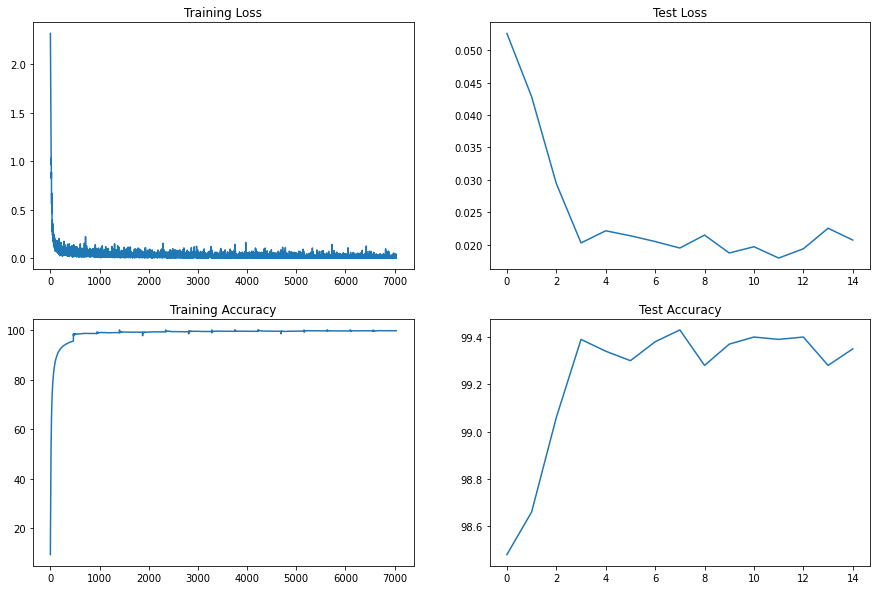

In [41]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

#### Analysis

The model is still overfitting, but there is still room to go higher as the training accuracy is 99.69. However, it looks like there are too many parameters which are causing the overfitting. We will reduce the number of parameters in the next iteration. Also, batchnorm and dropout have helped us reach minimum quicker this time. So we will keep them. 